# Installation

```bash
pip install pandas numpy matplotlib
```

If you get an error of `Original error was: libf77blas.so.3: cannot open shared object file: No such file or directory` (hiding at the very bottom of the error message) and are running Jupyter on a Raspberry Pi then:

```bash
sudo apt-get install libatlas-base-dev
```

In [6]:
# Set the K value that was used for these tests
start_k = 0.08979

# Set to the value of the target volume - in liters
target_volume = 2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Some formatting setup

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#aec7e8', '#1f77b4', '#ffbb78', '#ff7f0e', '#98df8a','#2ca02c', 
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
plt.rcParams['lines.linewidth'] = 1

#File path to the csv file
csv_file = "./cal-v31-2020-06-20-01.csv"

# Read in the file, and shift it to the start of the test
df = pd.read_csv(csv_file, sep="\t").shift(-82)

# Compute the volume - step 1, ms per sample
ms_diff = df['ms'] - df.shift(1, fill_value=0)['ms']
# Adjust so the first difference is zero
ms_diff[0] = 0

# Compute the volume - step 2, volume change per sample, adjusted SLM to L/s
volume_temp = ms_diff * (df['flow']/60)

# Compute the volume - step 3, cumulative sum
df['volume'] =  volume_temp.cumsum()

# Now for charting we'll add a volume * 100
df['volume_100'] = df['volume'] * 100

# And add a line for the target volume
df['target'] = target_volume * 100

# Add a max volume mark
df['volume_100_max'] = df['volume_100'].max()

In [8]:
# Plot the volume and flow before adjustment
#df.plot(x='ms', y=['flow', 'volume_100', 'volume_100_max', 'target'], grid=True, figsize=[24, 10])

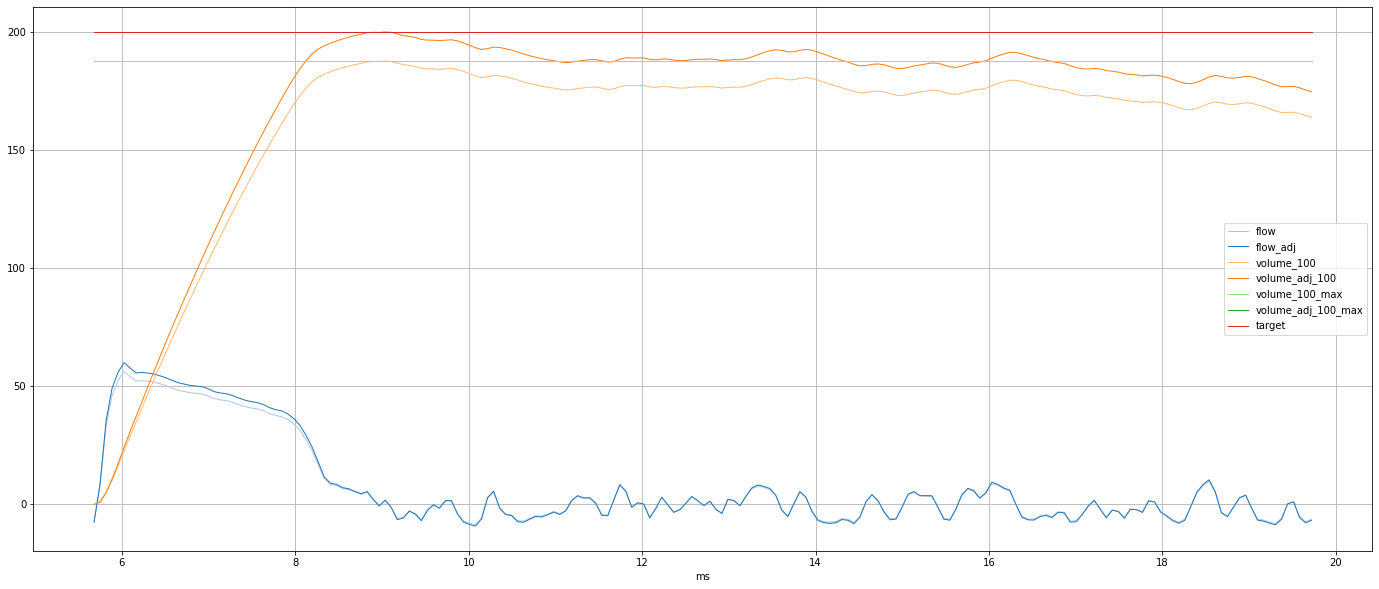

In [9]:
# Compute the adjusted K
new_k = start_k * (target_volume / df['volume'].max())

# Compute the new volume - step 1, compute an adjusted flow
df['flow_adj'] = (df['flow']/start_k)*new_k

# Compute the new volume - step 2, volume change per sample, adjusted SLM to L/s
volume_adj_temp = ms_diff * (df['flow_adj']/60)

# Compute the volume - step 3, cumulative sum
df['volume_adj'] =  volume_adj_temp.cumsum()

# Now for charting we'll add a volume * 100
df['volume_adj_100'] = df['volume_adj'] * 100

# Add a max volume mark
df['volume_adj_100_max'] = df['volume_adj_100'].max()

df.plot(x='ms', y=['flow', 'flow_adj', 'volume_100', 'volume_adj_100', 'volume_100_max', 'volume_adj_100_max', 'target'], grid=True, figsize=[24, 10])

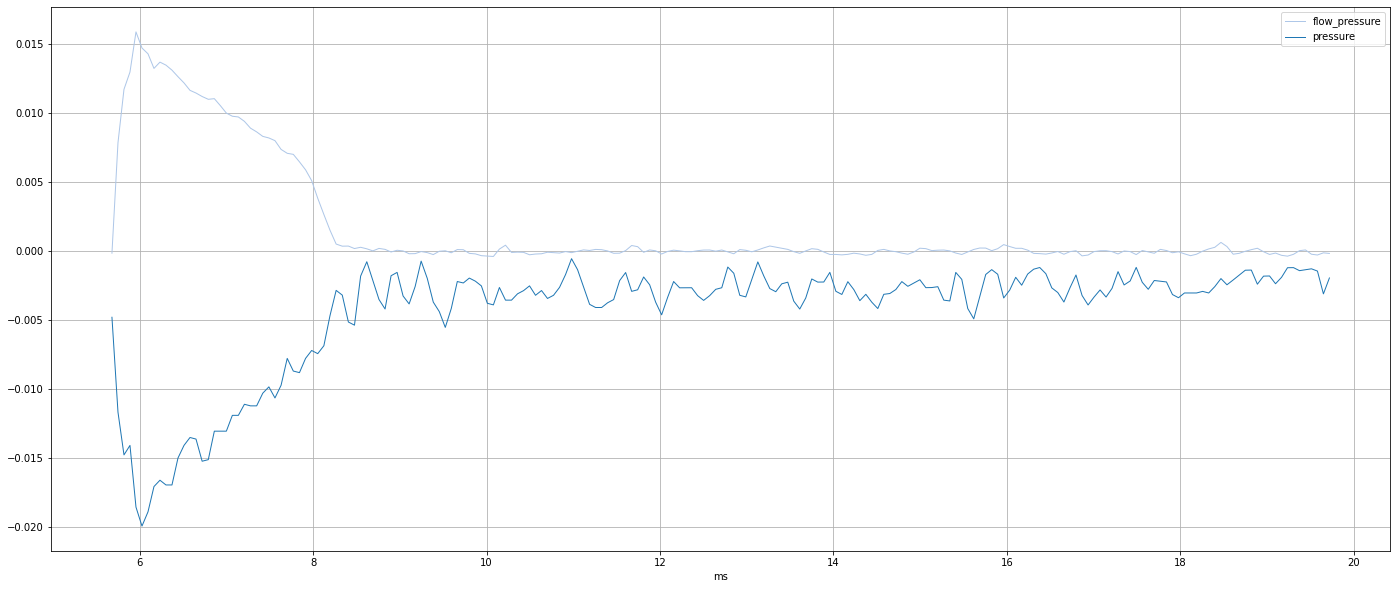

In [10]:
df.plot(x='ms', y=['flow_pressure', 'pressure'], grid=True, figsize=[24, 10])


In [11]:
new_k

0.09570862393895306